In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/gdrive


(1080, 1920, 3)


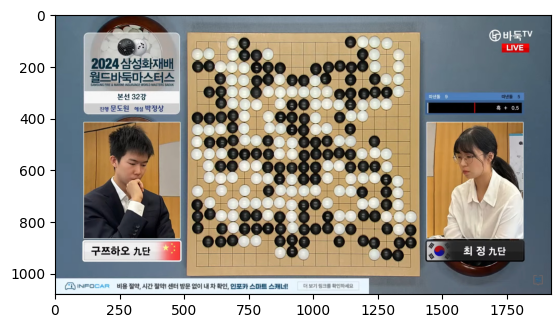

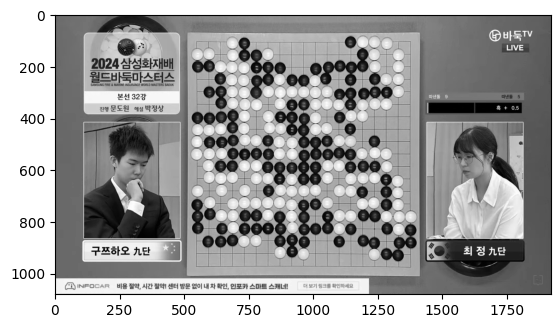

In [3]:
img = cv2.imread('/content/gdrive/MyDrive/디지털 영상처리 강의 관련/Images/Go_Board_Original.jpg')
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
#cv2_imshow(img)
plt.imshow(RGB_img)
plt.show()
plt.imshow(gimg, cmap='gray')

# 바둑판 위에서 흑돌의 개수, 백돌의 개수, 빈 공간(집)의 수를 세는 작업을 진행하는 것이 이번 과제의 목표

##바둑은 한마디로 "땅따먹기"와 유사한 게임, 게임이 종료되었을 때 자신의 집이 더 많으면 이기는 게임임.

##구체적인 계산 방식에는 한국-일본룰과 중국룰이 존재하는데, 한국및 일본 룰은 경기 종료후 본인이 따낸 상대방의 돌로 상대방의 집을 메운 뒤에 각자 남은 집을 계산하는 방식. 중국룰은 경기 종료후 자신의 집과 자신의 돌이 차지한 칸 수를 합산해 승자를 계산하는 방식.

## 실제 경기 시에는 한국 일본 룰이 편리한 면이 많지만, 따낸 돌의 개수를 알고 있어야 계산이 가능. 반면 중국 룰의 경우 경기 종료 후 화면만 보고도 계산이 가능 하므로 컴퓨터 상의 계산 및 영상처리를 통해 접근하기에 편리한 면이 있음.

## 이번 과제는 중국룰을 적용해서 바둑의 승패를 판정하는 것까지가 초기에 설정한 목표였으나 바둑판의 공백 중 어느 곳이 흑집이고, 어느 곳이 백집인지를 지정하여 레이블링 및 카운팅 하기가 쉽지 않은 관계로 우선 흑돌, 백돌, 여백(집)을 계수하는 것 까지만 진행

### 불러온 사진은 2024년 진행된 삼성화재배 32강, 최정 선수와 구쯔하오 선수의 바둑 경기의 유튜브 중계를 캡처한 것으로, 마지막 수가 두어진 직후의 모습. 바둑이 끝난 후 바둑판 사진을 찍은 것과 동일한 상황이라고 간주하고 과제를 진행.

### 우선 영상에서 관심영역인 바둑판만 분리해내는 과정을 진행

largest ares :  483823
largest area index :  146
largest area coordinate [x, y, w, h] :  [509, 71, 901, 941]


<Figure size 640x480 with 0 Axes>

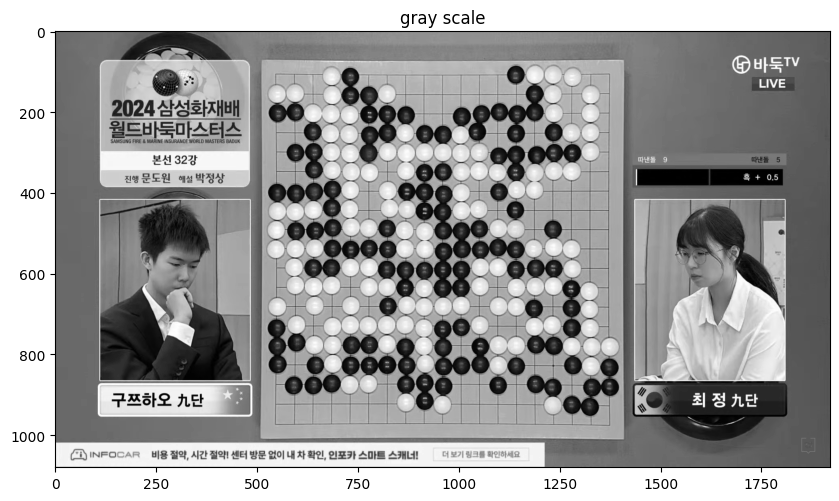

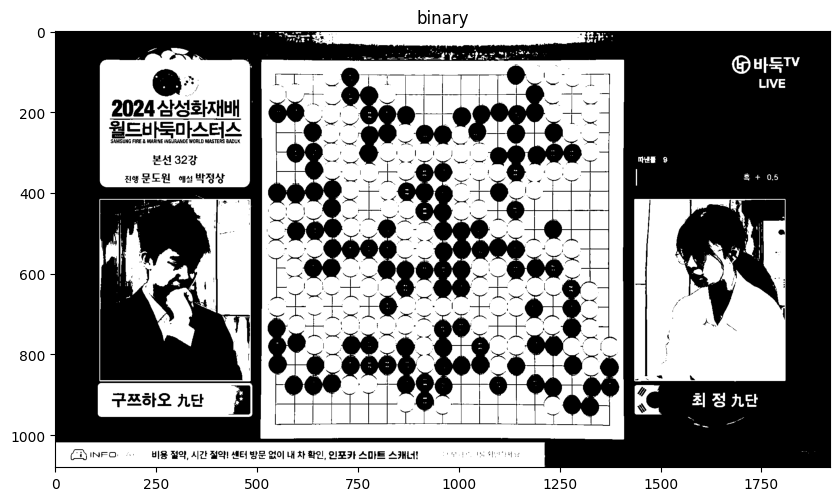

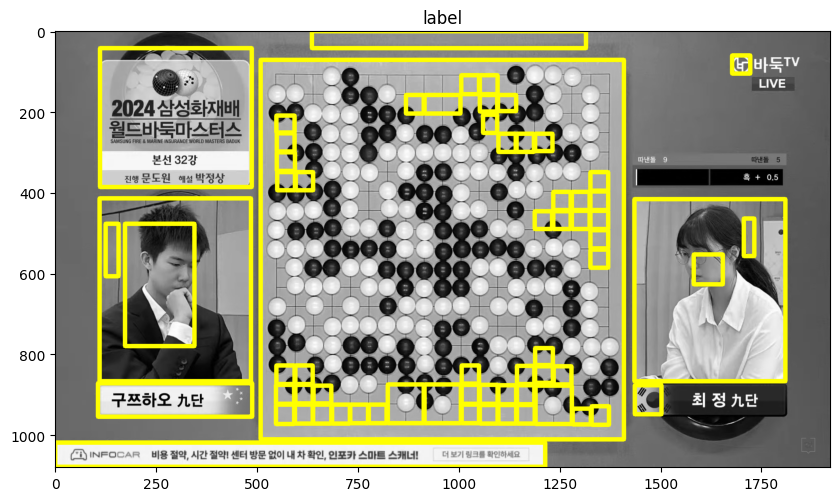

In [4]:
_, img_bin = cv2.threshold(gimg, 0, 255, cv2.THRESH_OTSU) # 오츠 알고리즘으로 이진화

dst = cv2.cvtColor(gimg, cv2.COLOR_GRAY2BGR) # 레이블과 함께 출력할 영상변

# 레이블링
cnt,labels, stats, centroids = cv2.connectedComponentsWithStats(img_bin)

largest_area = 0 # 가장 넓은 레이블의 넓이를 저장하기 위한 변수
area_index = 0 # 가장 넓은 레이블의 번호를 저장하기 위한 변수
largest_area_coord = [0, 0, 0, 0] # 가장 넓은 레이블의 시작 좌표와 치수를 저장할 리스트 변수

for i in range(1, cnt): # 0번부터 시작할 시 화면 전체를 하나의 레이블로 하는 변수가 지정됨에 주의
    (x, y, w, h, area) = stats[i]
    if area < 1000:
        continue # 넓이 1000 이하는 무시
    cv2.rectangle(dst, (x, y, w, h), (0, 255, 255), 10) # 레이블링된 영역을 선 굵기 10의 직사각형으로 표시
    if area > largest_area:
        largest_area = area # 가장 넓은 레이블의 넓이를 업데이트
        area_index = i # 가장 넓은 레이블의 번호를 업데이트
        largest_area_coord = list((x, y, w, h)) # 가장 넓은 레이블의 시작 좌표와 가로, 세로 길이를 업데이트

plt.figure(1)
plt.figure(figsize=(10, 10))
plt.title('gray scale')
plt.imshow(gimg, cmap='gray')

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.title('binary')
plt.imshow(img_bin, cmap='gray')

plt.figure(3)
plt.figure(figsize=(10, 10))
plt.title('label')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

print("largest ares : ", largest_area)
print("largest area index : ", area_index)
print("largest area coordinate [x, y, w, h] : ", largest_area_coord)

### 입력 영상에서 가장 큰 부분을 차지하는 부분이 바둑판일 것이라고 가정, 해당 영상에서는 가장 큰 영역 레이블이 바둑판이 됨을 확인(단, 영상 전체를 영역으로 하는 첫 번째 레이블은 제외하고 표시 및 계산함)

(911, 951)


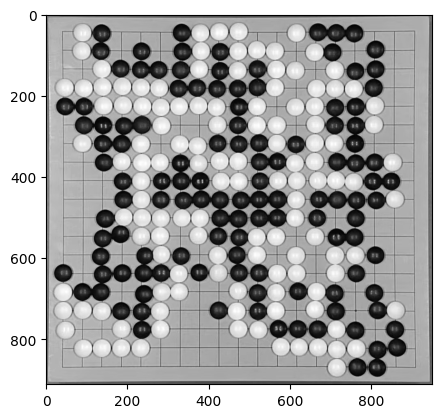

In [6]:
board_img = np.uint8(np.zeros(((largest_area_coord[2] + 10), largest_area_coord[3] + 10))) # 바둑판만 뽑아내 저장할 변수를 정의
# 앞서 가장 큰 영역에서 상하좌우로 5픽셀씩의 여유를 주고 추출할 예정이므로 가로 세로에 각각 20을 더해서 정의해줌

print(board_img.shape)

# 바둑판 이미지를 할당
for h in range(board_img.shape[1]):
    for w in range(board_img.shape[0]):
        board_img[w, h] = gimg[(largest_area_coord[1] -5 + h), (largest_area_coord[0] - 5 + w) ] # 바둑판 이미지를 할당

# 원본 사진에서의 좌표축과 객체 영역 지정시의 좌표축이 다른 듯, 서로 좌표축을 바꿔서 할당해줌

plt.imshow(board_img, cmap='gray')

바둑판 부분만 성공적으로 추출해냄을 확인

### 이제 히스토그램을 이용해 이진화 혹은 삼진화

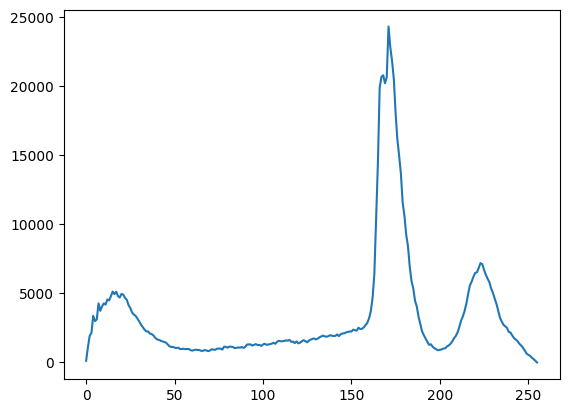

In [7]:
hist = cv2.calcHist([board_img], [0], None, [256], [0, 255])
plt.plot(hist)

삼진화 할 시 임계값으로 150, 200을 사용하는 것이 적당할 것으로 추측 가능

In [8]:
T1 = 200
T2 = 150

In [10]:
# 삼진화 된 바둑판 영상 출력을 위한 변수
board_Tri = np.zeros((board_img.shape[0], board_img.shape[1]))

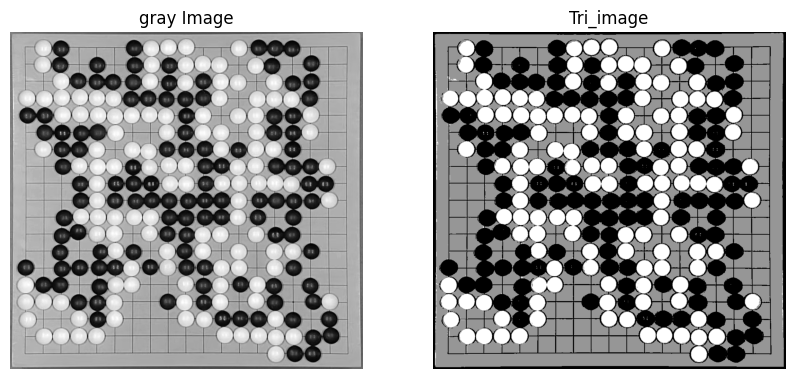

In [11]:
for h in range(board_img.shape[0]):
    for w in range(board_img.shape[1]):
        if(board_img[h, w] > T1):
            board_Tri[h, w] = 255
        elif(board_img[h, w] > T2):
            board_Tri[h, w] = 150
        else:
            board_Tri[h, w] = 0

# 그림을 화면에 출력
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("gray Image")
plt.imshow(board_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Tri_image")
plt.imshow(board_Tri, cmap='gray')
plt.axis("off")
plt.show()

비교적 성공적으로 삼진화가 수행됨을 확인

오츠 알고리즘을 이용해서 전역 임계값을 통한 이진화를 하더라도 영상의 정보를 적절히 담고 있지 못하다고 판단하여 삼진화를 수행했음. 이제 이를 이진화에 사용하여 다음 단계를 진행

### 먼저 바둑판 위의 백돌을 계수

#### 이진화 수행

In [12]:
white_stone_img = np.uint8(np.zeros((board_Tri.shape[0], board_Tri.shape[1]))) # 백돌만 남은 이미지를 저장할 변수

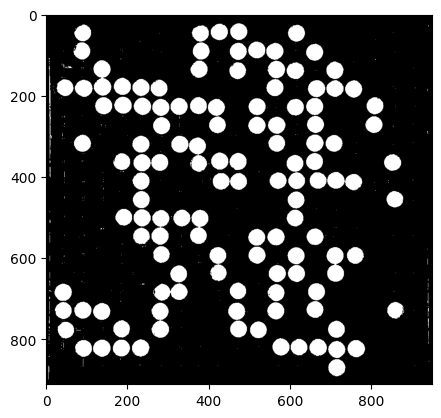

In [13]:
for h in range(board_Tri.shape[0]):
    for w in range(board_Tri.shape[1]):
        if board_Tri[h, w] > 200:
            white_stone_img[h, w] = board_Tri[h, w]

plt.imshow(white_stone_img, cmap='gray')

이진화는 되었으나 약간의 노이즈가 있음을 확인

#### 열림 및 닫힘 연산으로 노이즈 제거

In [14]:
white_stone_img_open = np.uint8(np.zeros((board_Tri.shape[0], board_Tri.shape[1]))) # 열림처리된 이미지를 저장할 변수

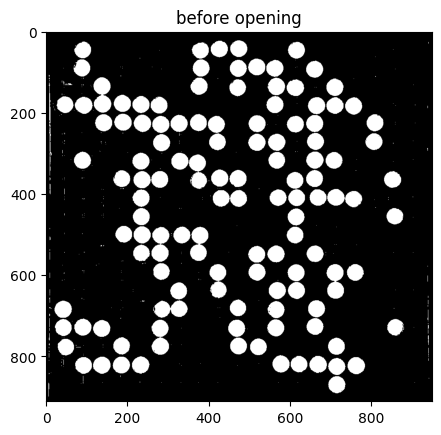

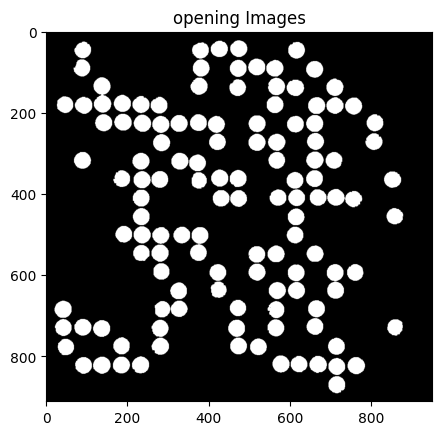

In [16]:
kernel = np.ones((5, 5), np.uint8) # 커널 정의
white_stone_img_open = cv2.morphologyEx(white_stone_img, cv2.MORPH_OPEN, kernel)

plt.title('before opening')
plt.imshow(white_stone_img, cmap='gray')

plt.figure(2)
plt.title('opening Images')
plt.imshow(white_stone_img_open, cmap='gray')

노이즈는 성공적으로 제거되었으나 일부 붙어 있는 객체가 있어 침식 및 팽창 연산으로 객체 분리 필요

#### 침식 및 팽창을 통한 객체 분리

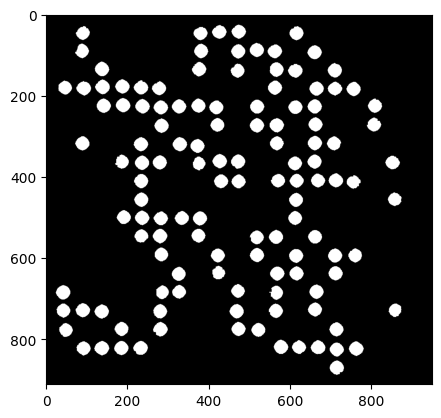

In [17]:
kernel = np.ones((3, 3), np.uint8)

white_stone_img_final = cv2.erode(white_stone_img_open, kernel, iterations = 3)

plt.imshow(white_stone_img_final, cmap='gray')

#### 이제 흰 돌의 계수(counting) 진행

In [18]:
num_w_stones, labels = cv2.connectedComponents(white_stone_img_final)
num_w_stones = num_w_stones - 1 # 배경까지 별개의 레이블로 카운팅 하므로 하나를 빼줘야 함
print('number of white stones :', num_w_stones)

number of white stones : 124


#### 다른 영역 레이블링 코드를 사용해 적절히 계수가 되었는지 검증

<Figure size 640x480 with 0 Axes>

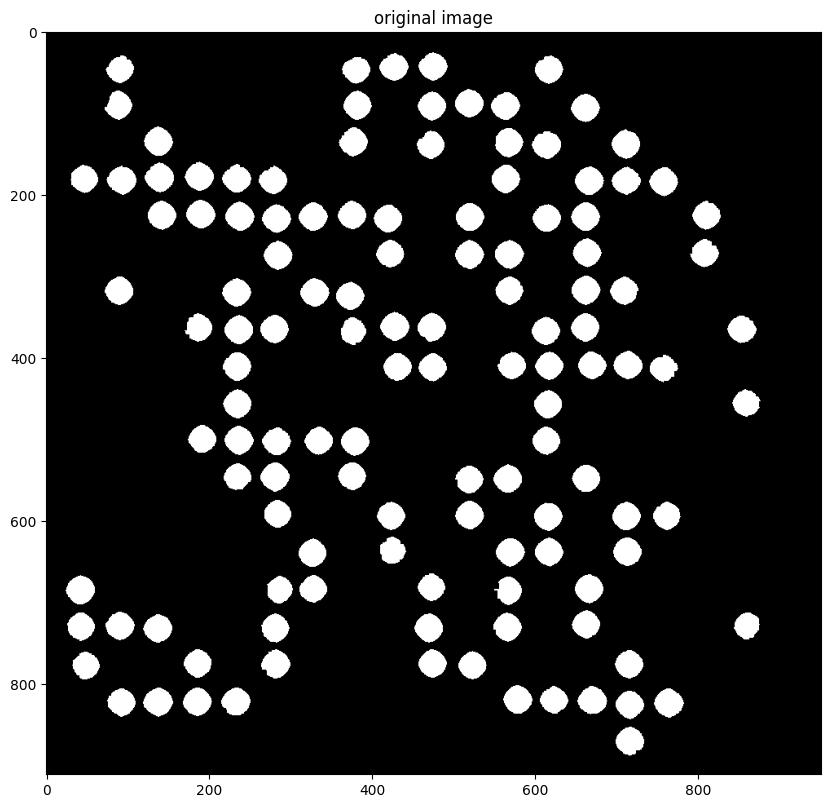

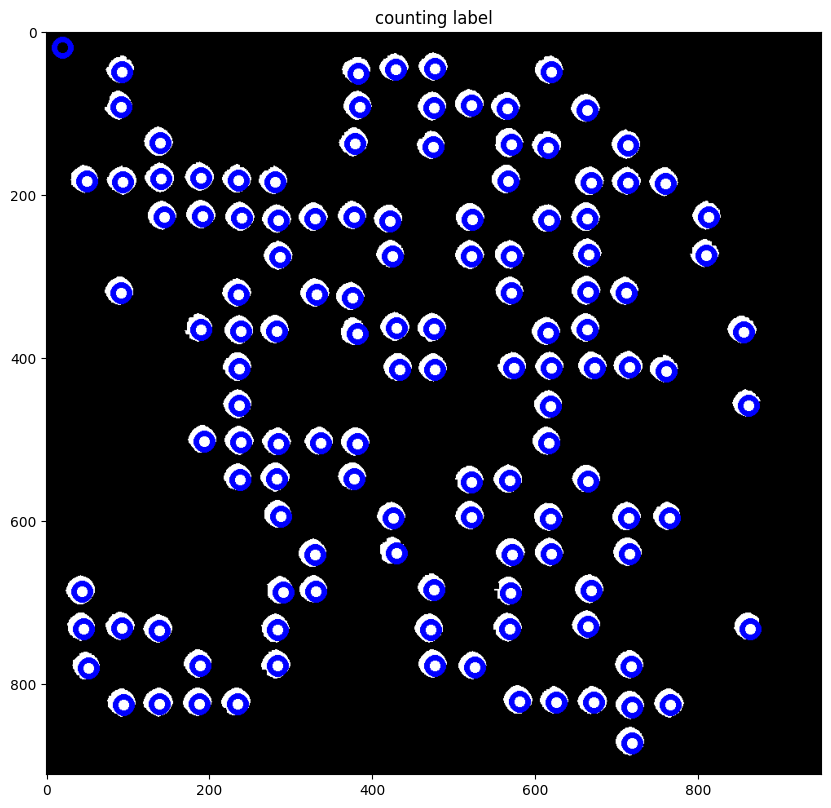

In [21]:
dst = cv2.cvtColor(np.copy(white_stone_img_final), cv2.COLOR_GRAY2BGR)

cnt,labels, stats, centroids = cv2.connectedComponentsWithStats(white_stone_img_final)
for i in range(cnt): # 이렇게 할 경우 배경을 하나의 레이블로 인식하여 계수하게 됨에 주의
    (x, y, w, h, area) = stats[i]
    if area < 10: # 넓이 10 이하의 레이블은 노이즈로 간주하고 패
        continue

    cv2.circle(dst, (x+20, y+20), 10, (255, 0, 0), 5) # 레이블링된 영역을 선 굵기 5의 원으로 표시

plt.figure(1)
plt.figure(figsize=(10, 10))
plt.title('original image')
plt.imshow(white_stone_img_final, cmap='gray')

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.title('counting label')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [22]:
print(cnt -1)

124


위에서 계수한 숫자와 동일함을 확인

### 이제 바둑판 위의 흑돌을 계수

#### 흑돌만 남기는 이진화를 진행

In [24]:
black_stone_img = np.uint8(np.ones((board_Tri.shape[0], board_Tri.shape[1])) * 255) # 해당 이미지를 저장할 변수

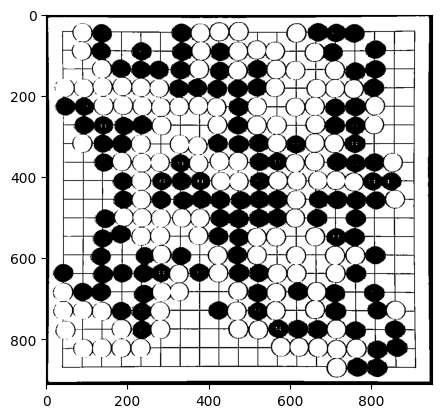

In [25]:
for h in range(board_Tri.shape[0]):
    for w in range(board_Tri.shape[1]):
        if board_Tri[h, w] < 100:
            black_stone_img[h, w] = board_Tri[h, w]

plt.imshow(black_stone_img, cmap='gray')

이 경우 바둑판의 선과 백돌의 경계선도 검은색이므로 추가적인 처리가 필요

#### 먼저 열림 및 닫힘 연산으로 바둑판의 선을 제거하고, 최종적으로 차 영상을 취해 흑돌만 남김

before opening
opening Images
opening Images2


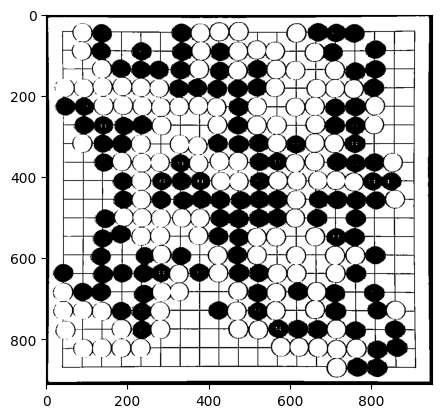

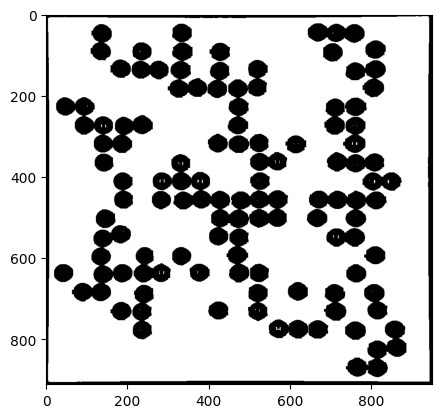

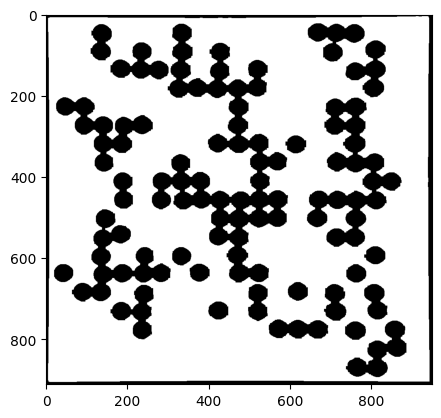

In [26]:
kernel = np.ones((7, 7), np.uint8)
black_stone_img_close = cv2.morphologyEx(black_stone_img, cv2.MORPH_CLOSE, kernel)
black_stone_img_close2 = cv2.morphologyEx(black_stone_img_close, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

print('before opening')
plt.imshow(black_stone_img, cmap='gray')

plt.figure(2)
print('opening Images')
plt.imshow(black_stone_img_close, cmap='gray')

plt.figure(3)
print('opening Images2')
plt.imshow(black_stone_img_close2, cmap='gray')

흑돌만 분리해내긴 했지만 각각의 돌을 분리하는 작업이 필요

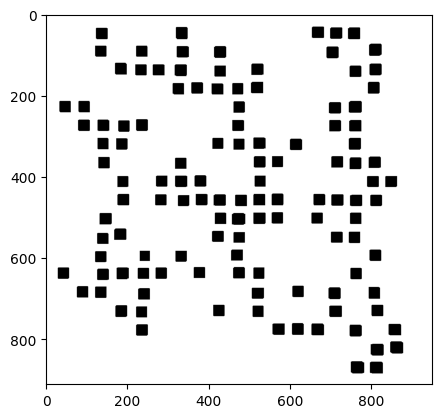

In [27]:
black_stone_img_final = black_stone_img_close2
kernel = np.ones((7, 7), np.uint8)

black_stone_img_final = cv2.dilate(black_stone_img_close2, kernel, iterations = 5) # 분리를 위한 침식연산
black_stone_img_final = cv2.erode(black_stone_img_final, kernel, iterations = 4) # 객체 사이즈 복원을 위한 팽창연산

plt.imshow(black_stone_img_final, cmap='gray')

형상은 다소 바뀌었지만 계수하기에 적절히 분리된 모습을 확인

#### 계수를 위한 코드는 흰 색을 객체로 인식하므로 색상 반전 수행

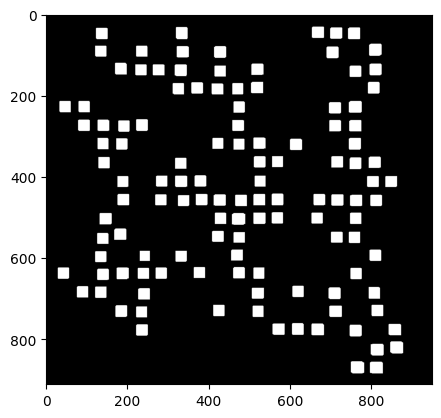

In [28]:
black_stone_img_final_flip = np.uint8(np.zeros((board_Tri.shape[0], board_Tri.shape[1]))) # 색상반전 이미지를 위한 변수

for h in range(board_Tri.shape[0]):
    for w in range(board_Tri.shape[1]):
        if black_stone_img_final[h, w] == 255:
            black_stone_img_final_flip[h, w] = 0 # 흰 색은 검은색으로
        else:
            black_stone_img_final_flip[h, w] = 255 # 나머지(검은색)는 흰 색으로

plt.imshow(black_stone_img_final_flip, cmap='gray')

In [30]:
num_b_stones, labels = cv2.connectedComponents(black_stone_img_final_flip)
num_b_stones -= 1 # 위에서와 같은 이유로 하나 제외
print('number of black :', num_b_stones)

number of black : 120


#### 계수의 정확성 검증 및 시각화

<Figure size 640x480 with 0 Axes>

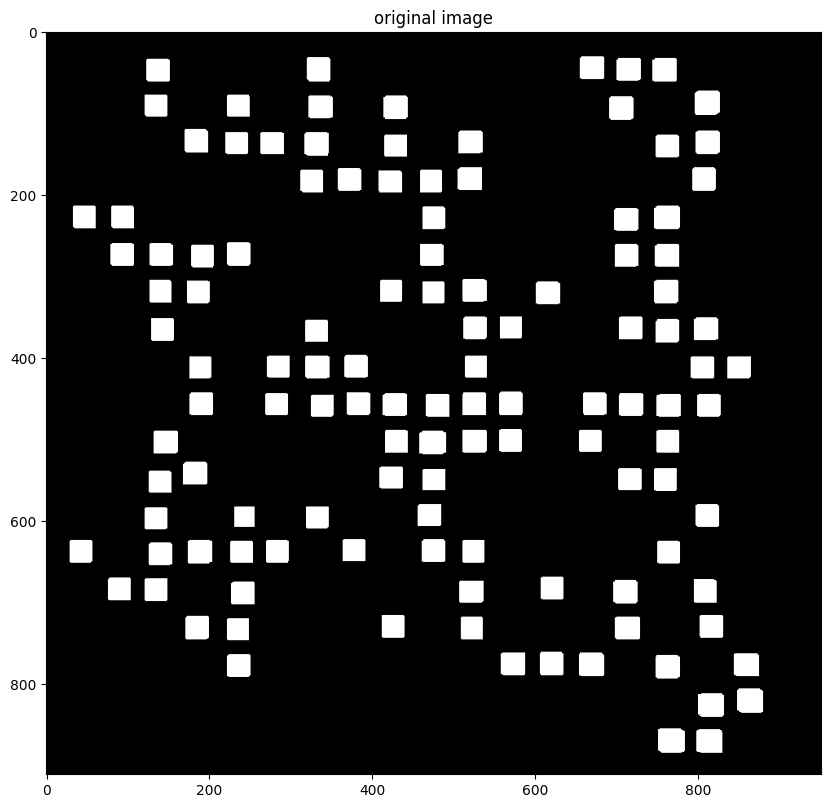

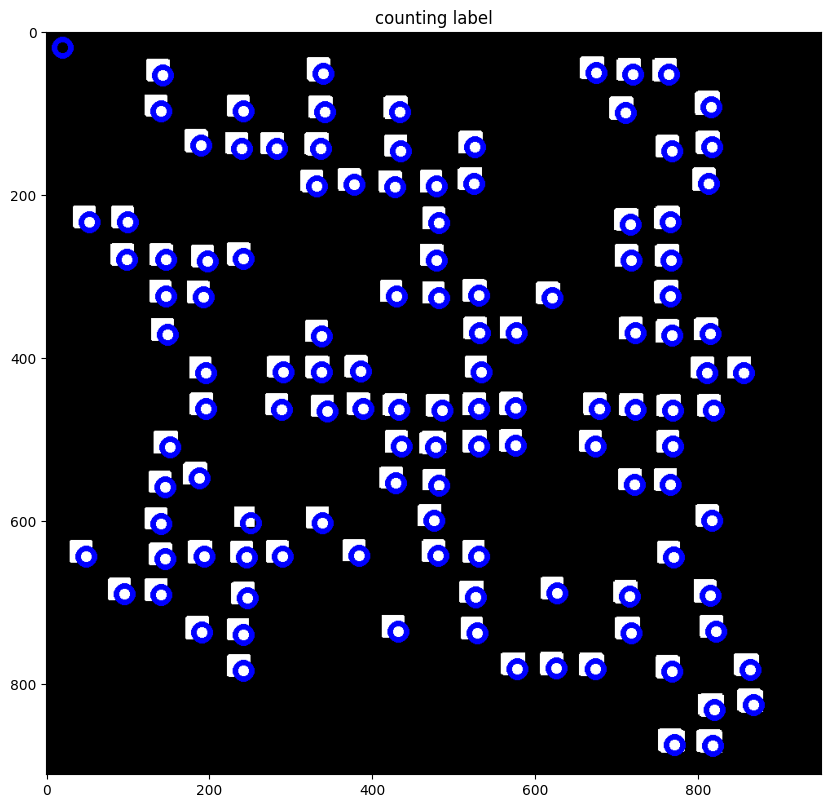

In [31]:
dst = cv2.cvtColor(np.copy(black_stone_img_final_flip), cv2.COLOR_GRAY2BGR)

cnt,labels, stats, centroids = cv2.connectedComponentsWithStats(black_stone_img_final_flip)
for i in range(cnt):
    (x, y, w, h, area) = stats[i]
    if area < 10:
        continue

    cv2.circle(dst, (x+20, y+20), 10, (255, 0, 0), 5) # 레이블링된 영역을 선 굵기 5의 원으로 표시

plt.figure(1)
plt.figure(figsize=(10, 10))
plt.title('original image')
plt.imshow(black_stone_img_final_flip, cmap='gray')

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.title('counting label')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [32]:
print(cnt-1)
# 배경까지 하나의 객체로 인식해서 레이블링 함에 주의 필요!

120


위에서 계수한 숫자가 정확, 적절함을 확인

### 이제 나머지 공간(집)을 계수

#### 먼저 바둑판만 배경으로 남기는 이진화 수행

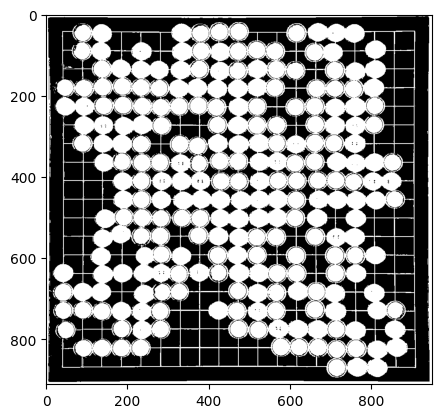

In [33]:
house = np.uint8(np.zeros((board_Tri.shape[0], board_Tri.shape[1])))

for h in range(board_Tri.shape[0]):
    for w in range(board_Tri.shape[1]):
        if board_Tri[h, w] > 200:
            house[h, w] = board_Tri[h, w]
        elif board_Tri[h, w] < 150:
            house[h, w] = 255

plt.imshow(house, cmap='gray')

#### 선만 남기기 위해 열림 및 닫힘, 차영상을 적용

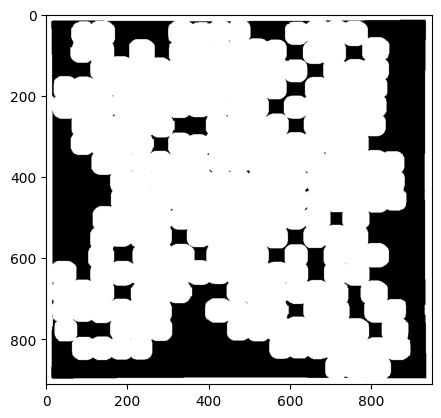

In [34]:
kernel = np.ones((5, 5), np.uint8)

house_img_open = cv2.morphologyEx(house, cv2.MORPH_OPEN, kernel)
house_img_open = cv2.dilate(house_img_open, kernel, iterations = 4)

plt.imshow(house_img_open, cmap='gray')

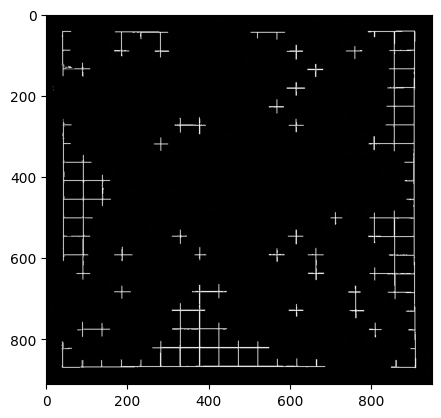

In [36]:
only_line = house - house_img_open

for h in range(only_line.shape[0]):
    for w in range(only_line.shape[1]):
        if only_line[h, w] < 0:
            only_line[h, w] = 0 # saturation

plt.imshow(only_line, cmap='gray')

바둑판의 선만 남기는 데 성공

#### 바둑에서는 교차점위에 착수를 하므로 교차점을 계수해야함. 교점만 분리해내는 처리가 필요

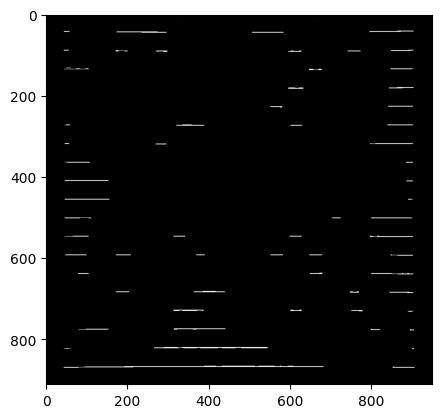

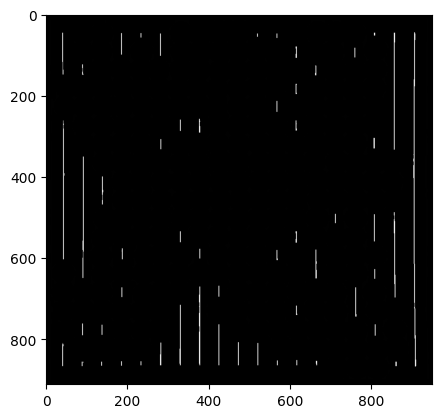

In [37]:
kernel_h = np.ones((1, 5), np.uint8) # 구조 요소를 조정
house_h = cv2.erode(only_line, kernel_h, iterations = 2)
plt.imshow(house_h, cmap='gray')

kernel_v = np.ones((5, 1), np.uint8) # 구조 요소를 조정
house_v = cv2.erode(only_line, kernel_v, iterations = 2)
plt.figure(2)
plt.imshow(house_v, cmap='gray')

먼저 수직선, 수평선만 남기는 각각의 영상을 만든 후 교짐합을 이용할 예정 먼저 남은 선을 더 두껍게하는 팽창연산 수행

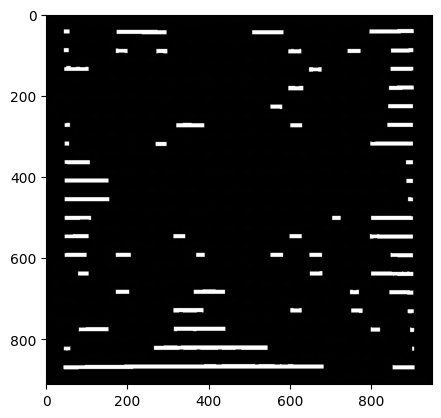

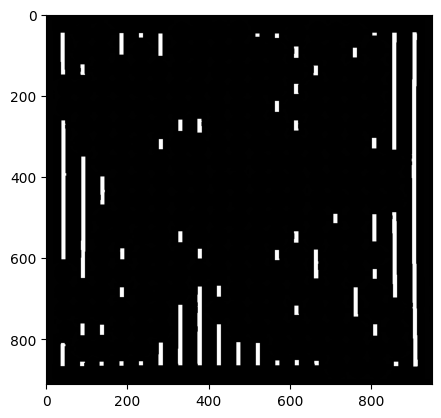

In [38]:
house_h = cv2.dilate(house_h, kernel_v, iterations = 2)
plt.imshow(house_h, cmap='gray')

house_v = cv2.dilate(house_v, kernel_h, iterations = 2)
plt.figure(2)
plt.imshow(house_v, cmap='gray')

#### AND 연산(교집합)

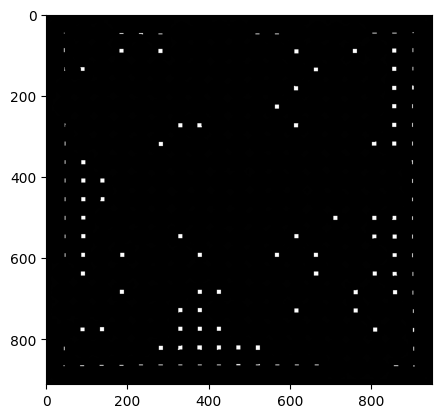

In [39]:
house_and = np.zeros((board_img.shape), np.uint8)
for h in range(board_img.shape[0]):
    for w in range(board_img.shape[1]):
        house_and[h, w] = np.int32(house_h[h, w]) & np.int32(house_v[h, w])

plt.imshow(house_and, cmap='gray')

#### 다시 팽창으로 크기 키워주기

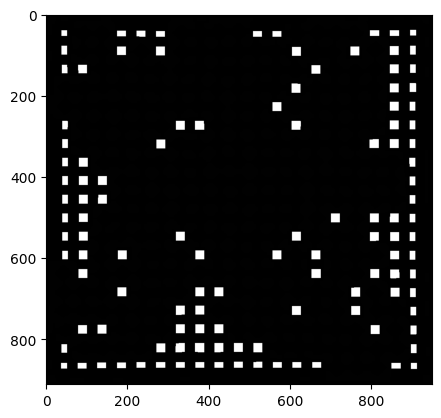

In [40]:
kernel = np.ones((5, 5), np.uint8)
house_img_final = cv2.dilate(house_and, kernel, iterations = 3)

plt.imshow(house_img_final, cmap='gray')

단, AND 연산을 거친 결과 영상이 이후의 계수 알고리즘에서 정상 동작하지 않아서 별도의 변수에 다시 저장

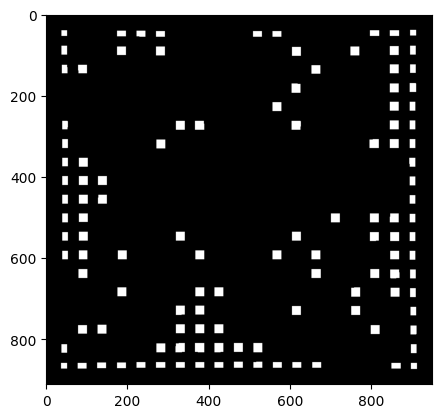

In [41]:
only_line_final = np.zeros((house_and.shape[0], house_and.shape[1]), np.uint8)

for h in range(only_line.shape[0]):
    for w in range(only_line.shape[1]):
        if house_img_final[h, w] > 10:
            only_line_final[h, w] = 255

plt.imshow(only_line_final, cmap='gray')

#### 계수 진행 및 검증

In [42]:
num_houses, labels = cv2.connectedComponents(only_line_final)
num_houses -= 1
print('number of total houses :', num_houses)

number of total houses : 117


<Figure size 640x480 with 0 Axes>

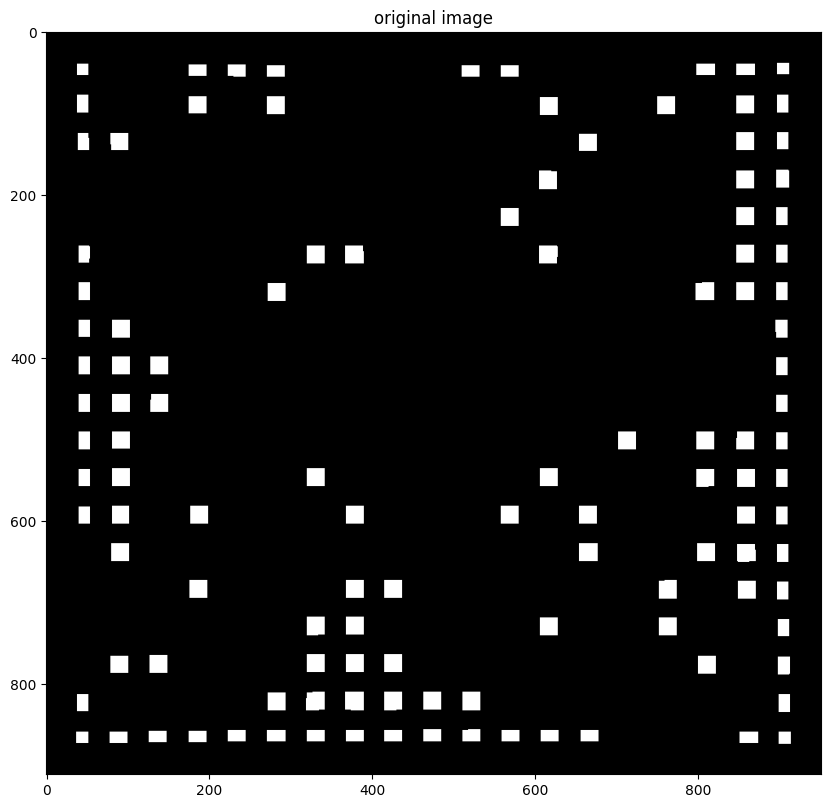

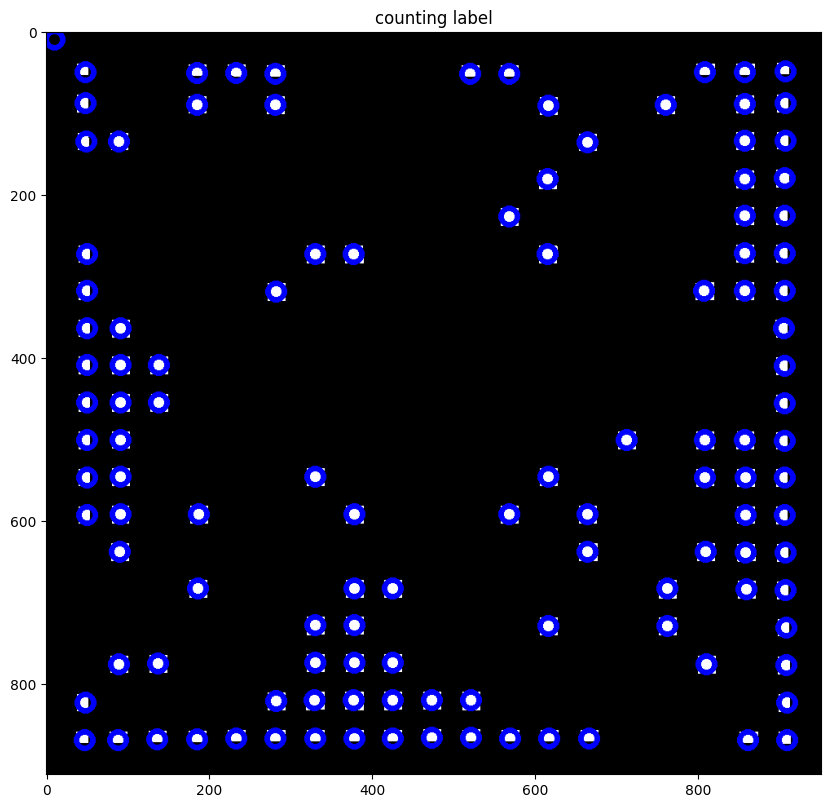

In [44]:
dst = cv2.cvtColor(np.copy(only_line_final), cv2.COLOR_GRAY2BGR)

cnt,labels, stats, centroids = cv2.connectedComponentsWithStats(only_line_final)
for i in range(cnt):
    (x, y, w, h, area) = stats[i]
    if area < 30:
        continue

    cv2.circle(dst, (x+10, y+10), 10, (255, 0, 0), 5) # 레이블링된 영역을 선 굵기 5의 원으로 표시

plt.figure(1)
plt.figure(figsize=(10, 10))
plt.title('original image')
plt.imshow(only_line_final, cmap='gray')

plt.figure(2)
plt.figure(figsize=(10, 10))
plt.title('counting label')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

In [45]:
print(cnt-1)

117


적절한 값임을 확인

## 최종 검증

### 바둑판은 19 * 19 = 361개의 칸이므로 계수한 값의 합이 361이 되어야 함

In [46]:
print("전체 합 : ", num_b_stones + num_w_stones + num_houses)

전체 합 :  361


적절하게 계산되었음을 확인

## 요약 및 고찰

위에서 구한 집의 개수에서 흑돌과 백돌을 분류하는 작업을 진행해야 계가(바둑에서의 승부 판정 절차)가 가능. 또한 정확한 계가를 위해서는 단순히 계수하는 것 뿐만 아니라 바둑판 위에 있기는 하지만 죽은 돌(사석)을 따로 계수해주는 과정도 필요.

따라서 지금까지 수행한 과정만으로는 초기에 의도한 목표를 완전히 달성하는 데에는 부족함. 다만, 디지털 영상처리를 통해서 이미지에서 원하는 객체를 분리해내고 계수하는 것이 충분히 가능하다는 것을 확인할 수 있었음. 특히 바둑판 위의 선을 어떤 방식으로 분리해낼 것인지 고민하는데 많은 시간이 소요됨. 또한 여러가지 라이브러리와 코드를 적용할 때 어떤 방식으로 작동하는지 숙지하고, 검증할 필요가 있음을 확인함. (처음에 전체합을 구했을 때 364가 나와서 당황했던 경험이 있음)